In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import cv2
from scipy.signal import butter, filtfilt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import cv2
from scipy.signal import butter, filtfilt

In [2]:
npy_path = r"C:\Users\admin\Desktop\Dataset\2025-06-22_18-45-24.447018\rgbt_combined\rgb_thermal_combined_resized.npz"


In [24]:
video_frames = np.load(npy_path)

ValueError: cannot reshape array of size 2147483648 into shape (557,1216,1936,3)

In [4]:
data = np.load(npy_path, mmap_mode='r')  # lub bez mmap
#print("Original shape:", data.shape)
#print("Original dtype:", data.dtype)
#print("Total elements:", data.size)

# N - liczba klatek
# H, W - wysokosc, szerokosc obrazka
# 4 - R, G, B, T 
frames      = data["frames"]      # shape: (N, H, W, 4)  uint8 
timestamps  = data["timestamps"]  # shape: (N,)         float64 (sekundy od 1970)


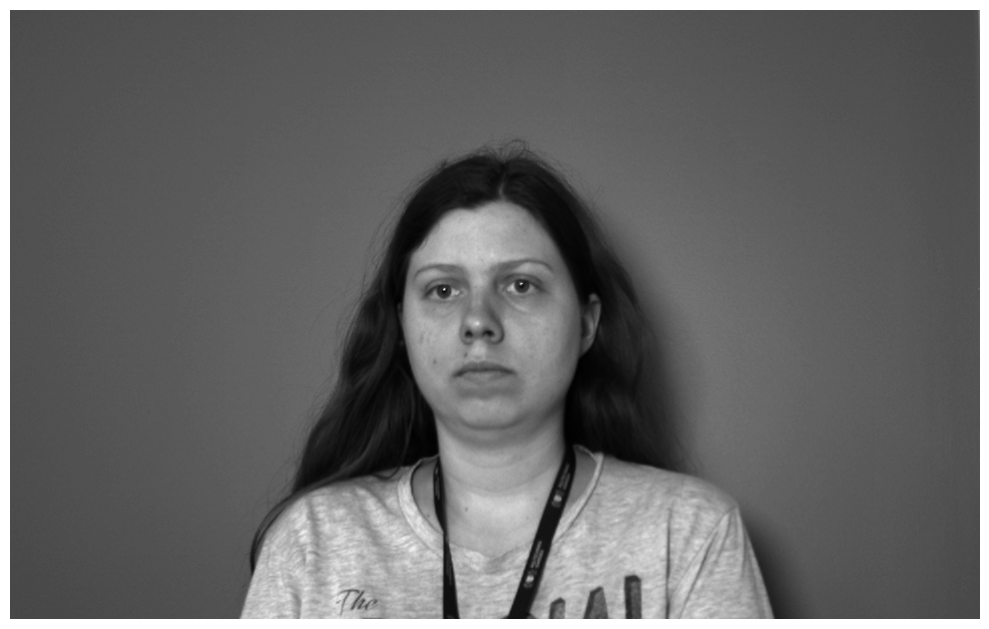

In [10]:
# podglag 150 klatki
frame = frames[150,:,:,:3]

plt.figure(figsize=(10, 10))
if frame.ndim == 2:
    norm = (frame - frame.min()) / (frame.max() - frame.min())
    plt.imshow(norm, cmap='gray')
elif frame.ndim == 3 and frame.shape[2] == 3:
    norm = (frame - frame.min()) / (frame.max() - frame.min())
    plt.imshow(norm.mean(axis=2), cmap='gray')
else:
    plt.imshow(frame, cmap='gray')

plt.axis('off')
plt.tight_layout()
plt.show()


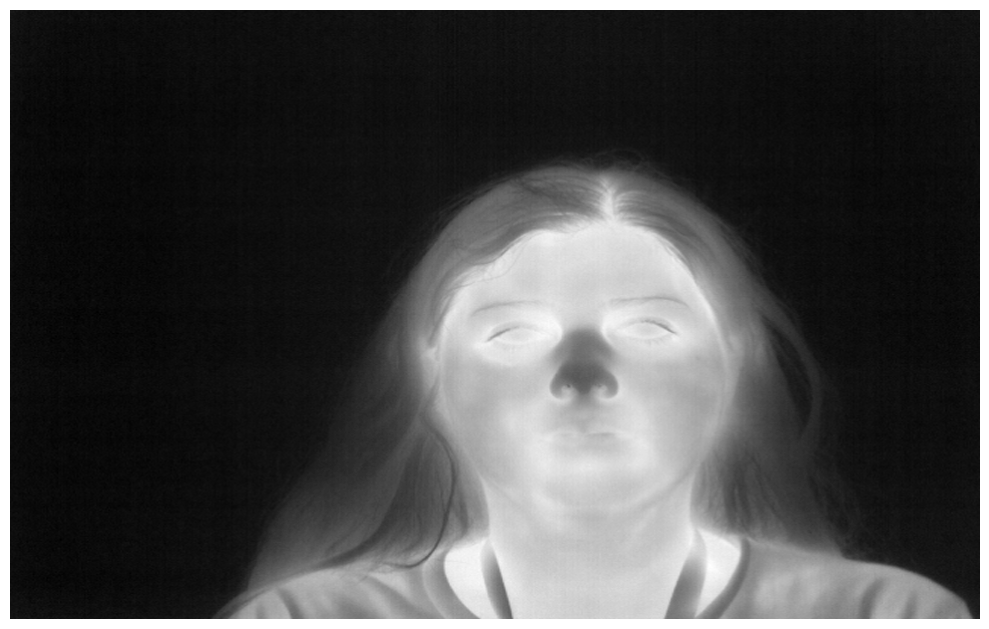

In [11]:
# podglag 150 klatki
frame = frames[150,:,:,3]

plt.figure(figsize=(10, 10))
if frame.ndim == 2:
    norm = (frame - frame.min()) / (frame.max() - frame.min())
    plt.imshow(norm, cmap='gray')
elif frame.ndim == 3 and frame.shape[2] == 3:
    norm = (frame - frame.min()) / (frame.max() - frame.min())
    plt.imshow(norm.mean(axis=2), cmap='gray')
else:
    plt.imshow(frame, cmap='gray')

plt.axis('off')
plt.tight_layout()
plt.show()

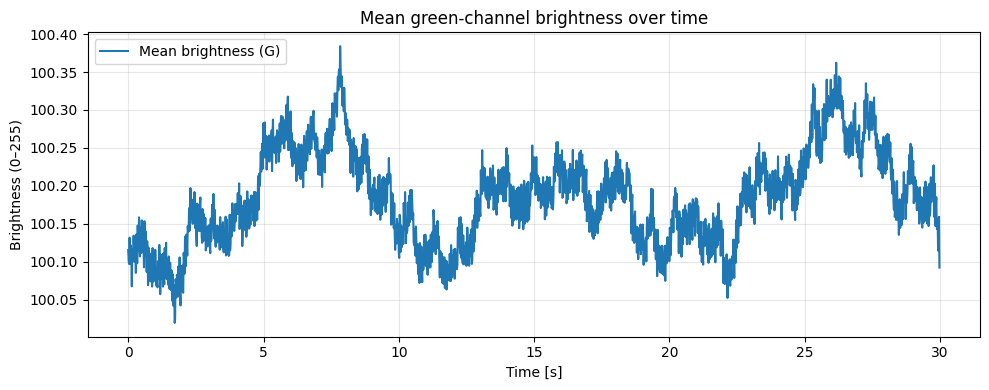

In [ ]:
t_rel = timestamps - timestamps[0]     # sekundy od poczatku nagrania
brightness = frames[..., 1].mean(axis=(1, 2))     # (N,)

assert len(t_rel) == len(brightness), "Timestamps == liczba klatek!"

# 4. Wykres 
plt.figure(figsize=(10, 4))
plt.plot(t_rel, brightness, label="Mean brightness (G)")
plt.xlabel("Time [s]")
plt.ylabel("Brightness (0–255)")
plt.title("Mean green-channel brightness over time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()



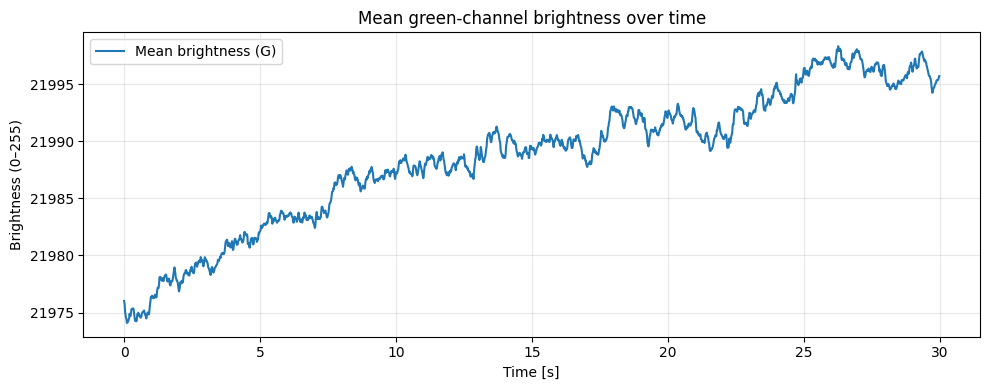

In [ ]:
# thermalne
brightness_t = frames[..., 3].mean(axis=(1, 2))     # (N,)

assert len(t_rel) == len(brightness_t), "Timestamps == liczba klatek!"

# 4. Wykres 
plt.figure(figsize=(10, 4))
plt.plot(t_rel, brightness_t, label="Mean brightness (G)")
plt.xlabel("Time [s]")
plt.ylabel("Brightness (0-255)")
plt.title("Mean green-channel brightness over time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

In [18]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

fs_est = 1.0 / np.mean(np.diff(t_rel))
print(f"{fs_est:.2f} FPS   filtrujemy 0.7–4.0 Hz")

filtered = butter_bandpass_filter(brightness,
                                  lowcut=0.7, highcut=4.0,
                                  fs=fs_est, order=4)

filtered_t = butter_bandpass_filter(brightness_t,
                                  lowcut=0.7, highcut=4.0,
                                  fs=fs_est, order=4)

60.01 FPS   filtrujemy 0.7–4.0 Hz


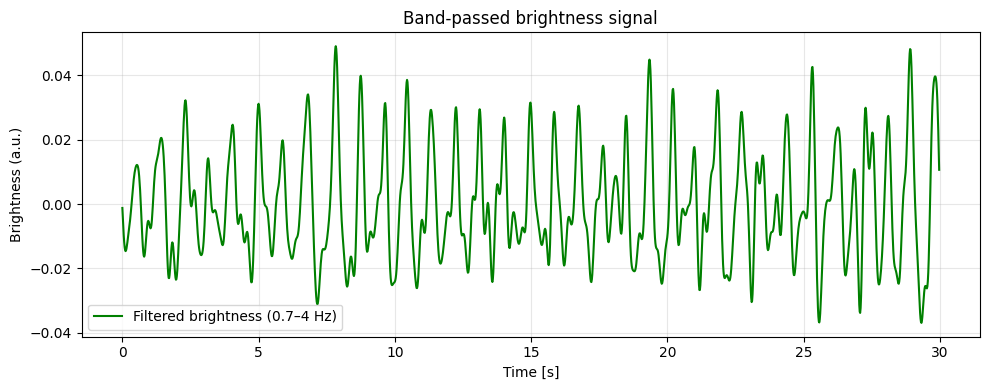

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(t_rel, filtered, color="green",
         label="Filtered brightness (0.7–4 Hz)")
plt.xlabel("Time [s]")
plt.ylabel("Brightness (a.u.)")
plt.title("Band-passed brightness signal")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

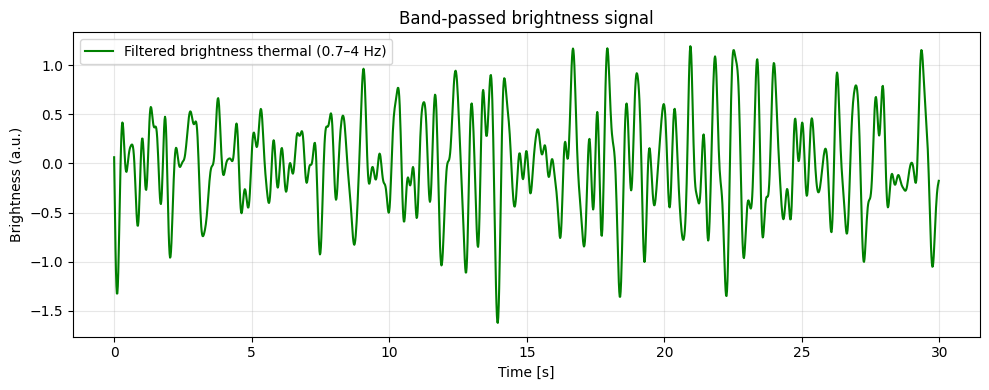

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(t_rel, filtered_t, color="green",
         label="Filtered brightness thermal (0.7–4 Hz)")
plt.xlabel("Time [s]")
plt.ylabel("Brightness (a.u.)")
plt.title("Band-passed brightness signal")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

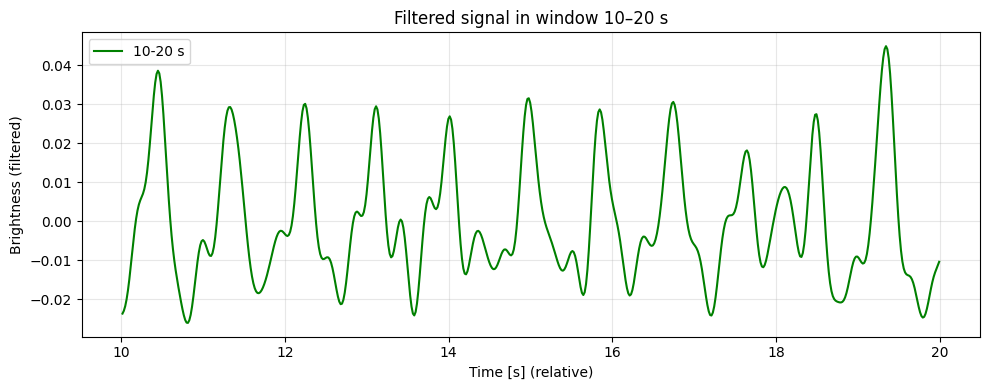

In [ ]:
# --- wycinek czasowy
start_s = 10     # poczatek okna [s] (czas wzgledny od t=0)
end_s   = 20     # koniec   okna [s]

mask = (t_rel >= start_s) & (t_rel <= end_s)

plt.figure(figsize=(10, 4))
plt.plot(t_rel[mask], filtered[mask],
         color="green", label=f"{start_s}-{end_s} s")
plt.xlabel("Time [s] (relative)")
plt.ylabel("Brightness (filtered)")
plt.title(f"Filtered signal in window {start_s}-{end_s} s")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()


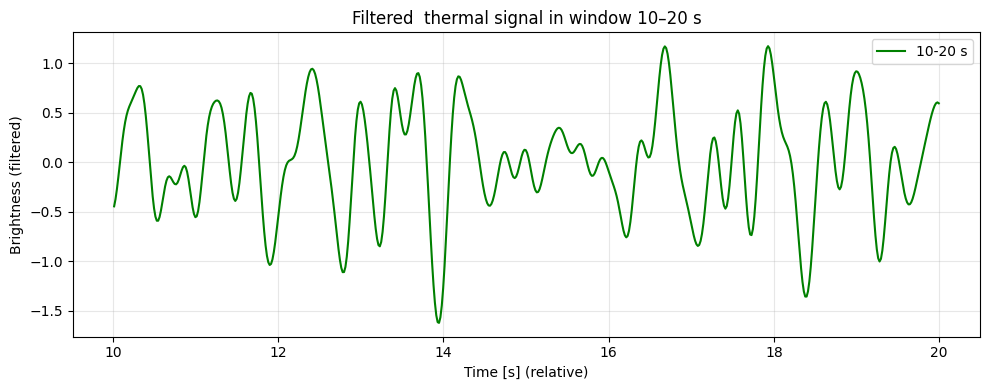

In [ ]:
# --- wycinek czasowy
start_s = 10     # poczatek okna [s] (czas wzgledny od t=0)
end_s   = 20     # koniec   okna [s]

mask = (t_rel >= start_s) & (t_rel <= end_s)

plt.figure(figsize=(10, 4))
plt.plot(t_rel[mask], filtered_t[mask],
         color="green", label=f"{start_s}-{end_s} s")
plt.xlabel("Time [s] (relative)")
plt.ylabel("Brightness (filtered)")
plt.title(f"Filtered  thermal signal in window {start_s}–{end_s} s")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()


✓ wykryto przesunięcie +2 h → dopasowanie 2964 punktów HL7


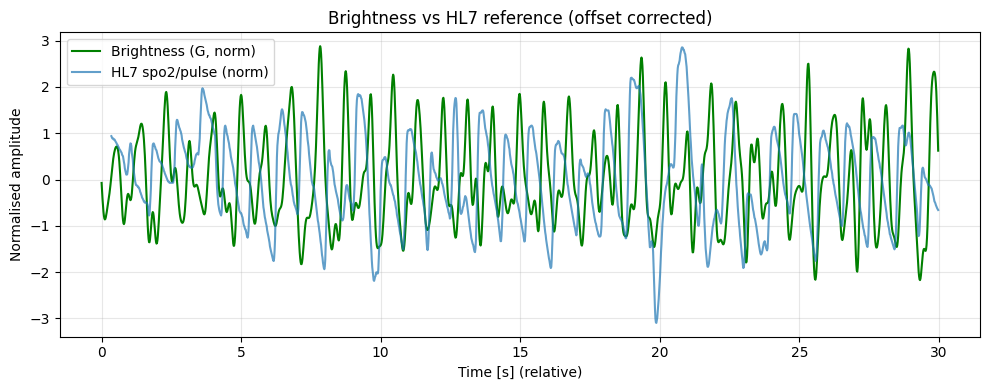

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

#  2. HL7 
hl7_path = r"C:\Users\admin\Desktop\Dataset\2025-06-22_18-45-24.447018\hl7\spo2_timebase.csv"
hl7 = pd.read_csv(hl7_path, sep=";")           # naglowek: t_ms;iso_utc;spo2
hl7["t_ms"] = pd.to_numeric(hl7["t_ms"], errors="coerce")
hl7["spo2"] = pd.to_numeric(hl7["spo2"], errors="coerce")
hl7.dropna(subset=["t_ms", "spo2"], inplace=True)

hl7_sec = hl7["t_ms"].to_numpy() / 1000.0      # epoch UTC (s)
hl7_ref = hl7["spo2"].to_numpy()

# 3. znajdz przesuniecie godzinowe 
possible_shifts = np.arange(-12, 13) * 3600        # -12h - +12h
best_shift = None
best_overlap = -1

for shift in possible_shifts:
    rel = hl7_sec - (timestamps[0] + shift)
    overlap = (rel.min() <= t_rel.max()) and (rel.max() >= t_rel.min())
    if overlap:
        # ile w osi wideo
        n_inside = ((rel >= t_rel.min()) & (rel <= t_rel.max())).sum()
        if n_inside > best_overlap:
            best_overlap, best_shift = n_inside, shift

if best_shift is None:
    raise RuntimeError("Nie znaleziono zadnego przesuniecia godzinowego z nakladaniem danych.")

print(f" wykryto przesuniecie {best_shift/3600:+.0f} h "
      f" dopasowanie {best_overlap} punktow HL7")

#  4. znormalizowane sygnaly 
hl7_t_rel = hl7_sec - (timestamps[0] + best_shift)
ref_interp = np.interp(t_rel, hl7_t_rel, hl7_ref, left=np.nan, right=np.nan)

def zscore(x):
    mu, sd = np.nanmean(x), np.nanstd(x)
    return (x - mu) / sd if sd else np.zeros_like(x)

bright_norm = zscore(filtered)
ref_norm    = zscore(ref_interp)

#  5. wykres 
plt.figure(figsize=(10,4))
plt.plot(t_rel, bright_norm, label="Brightness (G, norm)", color="green")
plt.plot(t_rel, ref_norm,    label="HL7 spo2/pulse (norm)", alpha=0.7)
plt.xlabel("Time [s] (relative)")
plt.ylabel("Normalised amplitude")
plt.title("Brightness vs HL7 reference (offset corrected)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


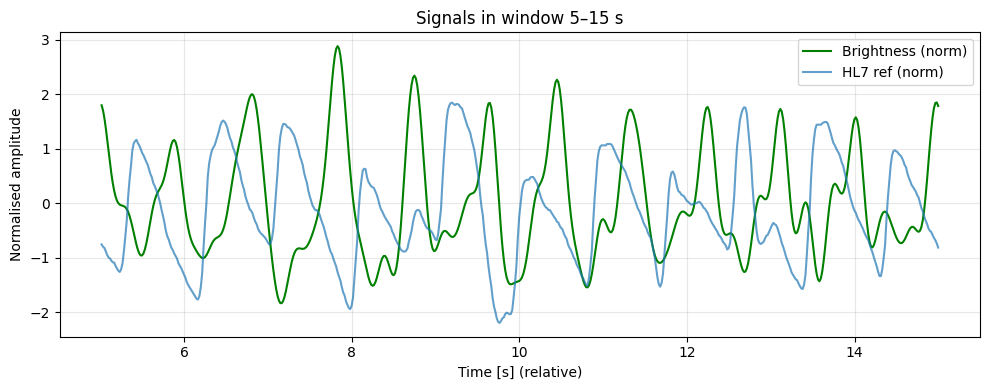

In [ ]:
win_start, win_end = 5, 15        # [s] od poczatku nagrania
mask_zoom = (t_rel >= win_start) & (t_rel <= win_end)

plt.figure(figsize=(10, 4))
plt.plot(t_rel[mask_zoom], bright_norm[mask_zoom],
         label="Brightness (norm)", color="green")
plt.plot(t_rel[mask_zoom], ref_norm[mask_zoom],
         label="HL7 ref (norm)", alpha=0.7)
plt.xlabel("Time [s] (relative)")
plt.ylabel("Normalised amplitude")
plt.title(f"Signals in window {win_start}-{win_end} s")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

 wykryto przesunięcie +2 h  dopasowanie 2964 punktów HL7


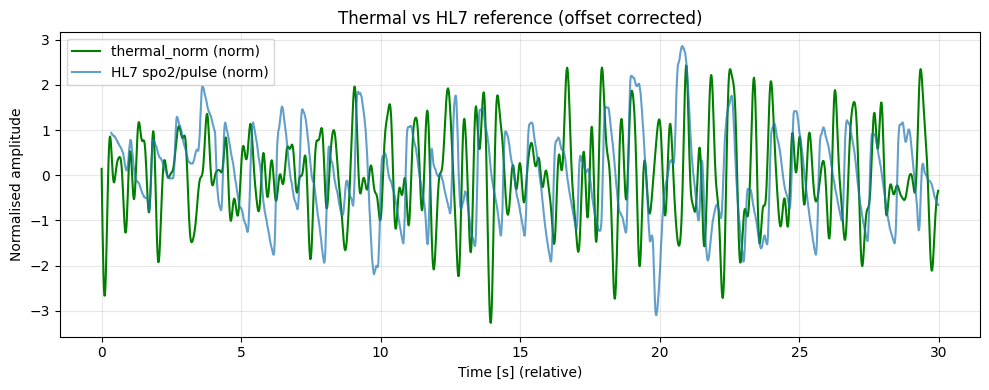

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# Thermal
# frames  (mmap)  -> brightness thermal
# timestamps      -> sekundy od 1970 (czas lokalny)
# filtered        -> po filtrze 0.7-4 Hz
# t_rel           -> timestamps - timestamps[0]
# 

#  2. HL7 
hl7_path = r"C:\Users\admin\Desktop\Dataset\2025-06-22_18-45-24.447018\hl7\spo2_timebase.csv"
hl7 = pd.read_csv(hl7_path, sep=";")           # naglowek: t_ms;iso_utc;spo2
hl7["t_ms"] = pd.to_numeric(hl7["t_ms"], errors="coerce")
hl7["spo2"] = pd.to_numeric(hl7["spo2"], errors="coerce")
hl7.dropna(subset=["t_ms", "spo2"], inplace=True)

hl7_sec = hl7["t_ms"].to_numpy() / 1000.0      # epoch UTC (s)
hl7_ref = hl7["spo2"].to_numpy()

# 3. znajdz przesuniecie godzinowe 
possible_shifts = np.arange(-12, 13) * 3600        # -12h - +12h
best_shift = None
best_overlap = -1

for shift in possible_shifts:
    rel = hl7_sec - (timestamps[0] + shift)
    overlap = (rel.min() <= t_rel.max()) and (rel.max() >= t_rel.min())
    if overlap:
        # ile w osi wideo
        n_inside = ((rel >= t_rel.min()) & (rel <= t_rel.max())).sum()
        if n_inside > best_overlap:
            best_overlap, best_shift = n_inside, shift

if best_shift is None:
    raise RuntimeError("Nie znaleziono zadnego przesuniecia godzinowego z nakladaniem danych.")

print(f" wykryto przesuniecie {best_shift/3600:+.0f} h "
      f" dopasowanie {best_overlap} punktow HL7")

#  4. znormalizowane sygnaly 
hl7_t_rel = hl7_sec - (timestamps[0] + best_shift)
ref_interp = np.interp(t_rel, hl7_t_rel, hl7_ref, left=np.nan, right=np.nan)

def zscore(x):
    mu, sd = np.nanmean(x), np.nanstd(x)
    return (x - mu) / sd if sd else np.zeros_like(x)

thermal_norm = zscore(filtered_t)
ref_norm    = zscore(ref_interp)

#  5. wykres 
plt.figure(figsize=(10,4))
plt.plot(t_rel, thermal_norm, label="thermal_norm (norm)", color="green")
plt.plot(t_rel, ref_norm,    label="HL7 spo2/pulse (norm)", alpha=0.7)
plt.xlabel("Time [s] (relative)")
plt.ylabel("Normalised amplitude")
plt.title("Thermal vs HL7 reference (offset corrected)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


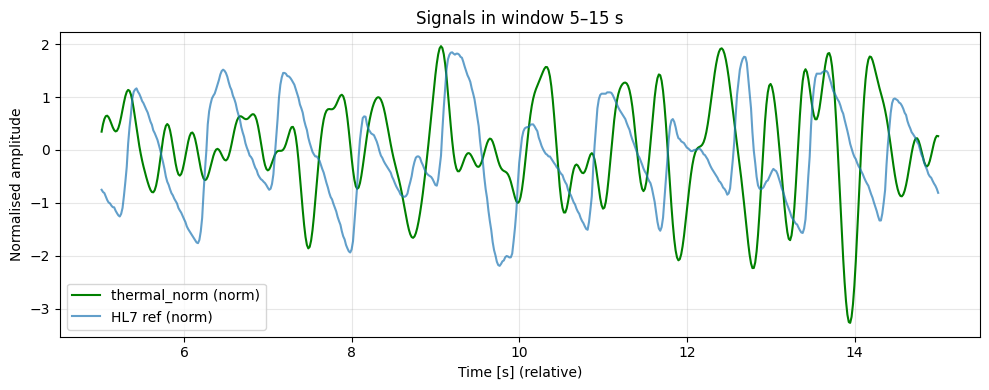

In [35]:
win_start, win_end = 5, 15        # [s] od początku nagrania
mask_zoom = (t_rel >= win_start) & (t_rel <= win_end)

plt.figure(figsize=(10, 4))
plt.plot(t_rel[mask_zoom], thermal_norm[mask_zoom],
         label="thermal_norm (norm)", color="green")
plt.plot(t_rel[mask_zoom], ref_norm[mask_zoom],
         label="HL7 ref (norm)", alpha=0.7)
plt.xlabel("Time [s] (relative)")
plt.ylabel("Normalised amplitude")
plt.title(f"Signals in window {win_start}–{win_end} s")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
#boson+u235c